# Alternus Vera 

Course code : **CMPE-257** 
    
Group name : **SAY**
    
Name: **Yuhua He 013803959** 

-----

GitHub URL: https://github.com/three-cobbler/AlternusVera


### Liar Liar Pants on Fire Dataset Description 
- It has 3 files test, training and valid.
- Each file has 14 columns
    
    Column 1: the ID of the statement ([ID].json).
    
    Column 2: the label.
    
    Column 3: the statement.
    
    Column 4: the subject(s).
    
    Column 5: the speaker.
    
    Column 6: the speaker's job title.
    
    Column 7: the state info.
    
    Column 8: the party affiliation.
    
    Column 9-13: the total credit history count, including the current statement.
    
    Column 14: the context (venue / location of the speech or statement).

### Process of My Approach 
- Load the Data
- Distillation Process
    - Data Cleaning and Text Preprocessing
    - Visualization
- **Feature 1 :** Corpus Structure
- Vector Classification Modeling 
- Ranking and Importance
- Merge all features and individual contributions
- Form Polynomial Equation 
    

### Feature Selection
**List top Features Selected based on research articles**



### Team Contributions example:

|Features  |  Member |
|-----|-----|
| Corpus Structure                         |  Yuhua He |  
| Feature name(s)                 |  Samuel Yang | 
| Feature name(s)                   |  Yuanzhe Li  |   

 
#### Enrichment Dataset Details

- Real news data from published articles (https://www.kaggle.com/snapcrack/all-the-news --- articles1)
- Fake news data from Kaggle (https://www.kaggle.com/mrisdal/fake-news)

#### Libraries Used 

- NLTK 
- Gensim 
- Numpy
- Pandas
- CSV
- WordCloud
- Seaborn
- Scipy
- Regualr Expression
- Matplotlib
- Sklearn 


#### What did I try and What worked? 

> For Corpus structure feature, I tried applying unigram, bigrams, 3-grams, etc from cleaned content, vectorizing the documents with TF-IDF, then apply multiple classification algorithms such as Logistic Regression, Random Forest, etc. Comparing the F1 scores for each. Vectorizing each document based on ngrams do give me the the improvements on the accuracy model provides, I also played around with the C values passed in LogisticRegression class, which also gives me slight improvements on the accuracy score.

#### What did not work?

> Even though ngrams gave the difference on the model accuracy, but with orignal liar-liar dataset, the model accuracy didn't have too much diffence, it ranges between 50% - 58%, even though I applied different classification algorithms, the model accuracy still not improved that much.


#### What alternatives did you try?

> I tried data enrichment by getting additional real news data and fake news data from kaggle, cleaned the feature content and text columns by applying and similar cleanning logic used in the original data set, enriched with the orignal dataset and feed into the same model again, and got significant improvement on the model accuracy, it goes up to 87%(logistic regression), 89%(random forest) with unigram.

----

### Reading the Data

In [1]:
import pandas as pd
import numpy as np
import csv
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from nltk.stem.porter import PorterStemmer
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from string import punctuation
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import re
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
import matplotlib.pyplot as plt
from scipy import sparse
# Code source: https://degravek.github.io/project-pages/project1/2017/04/28/New-Notebook/
# Dataset from Chakraborty et al. (https://github.com/bhargaviparanjape/clickbait/tree/master/dataset)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yuhuahe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yuhuahe/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# Read the test, training and valid data from files
# Header = 0 indicates that the first line of the file contains column names,
# As there is no Header, create a column names for each column in the dataset
# delimiter = \t indicates that the fields are seperated by tabs, and 


test_filename = 'input_data/dataset/test.tsv'
train_filename = 'input_data/dataset/train.tsv'
valid_filename = 'input_data/dataset/valid.tsv'

colnames = ['jsonid', 'label', 'headline_text', 'subject', 'speaker', 'speakerjobtitle', 'stateinfo','partyaffiliation', 'barelytruecounts', 'falsecounts','halftruecounts','mostlytrueocunts','pantsonfirecounts','context']

train_news = pd.read_csv(train_filename, sep='\t', names = colnames, error_bad_lines=False)
test_news = pd.read_csv(test_filename, sep='\t', names = colnames, error_bad_lines=False)
valid_news = pd.read_csv(valid_filename, sep='\t', names = colnames, error_bad_lines=False)

In [3]:
# Display check the dimensions and the first 2 rows of the file.

print('train dim:',train_news.shape, 'test dim:', test_news.shape)
train_news.iloc[0:2]

train dim: (10240, 14) test dim: (1267, 14)


,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.


## Data Cleaning and Text Preprocessing 

*Steps included in the preprocessing:*
- Remove Special Characters and Punctuations
- Lower case the news
- Tokenization
- Remove Stop Words
- Lemmatization
- Stemming 
- Spell Check 

###  Putting It All Together 

To make the code reusable, we need to create a function that can be called many times.

In [373]:
import re

def cleaning(raw_news):
    import nltk
    
    # 1. Remove non-letters/Special Characters and Punctuations
    news = re.sub("[^a-zA-Z]", " ", str(raw_news))
    
    # 2. Convert to lower case.
    news =  news.lower()
    
    # 3. Tokenize.
    news_words = nltk.word_tokenize( news)
    
    # 4. Convert the stopwords list to "set" data type.
    stops = set(nltk.corpus.stopwords.words("english"))
    
    # 5. Remove stop words. 
    words = [w for w in  news_words  if not w in stops]
    
    # 6. Lemmentize 
    wordnet_lem = [ WordNetLemmatizer().lemmatize(w) for w in words ]
    
    # 7. Stemming
    stems = [nltk.stem.SnowballStemmer('english').stem(w) for w in wordnet_lem ]
    
    # 8. Join the stemmed words back into one string separated by space, and return the result.
    return " ".join(stems)

In [5]:
import time
# clean training and test data 
# create new column "tokenized"
t1 = time.time()

# Add the processed data to the original data. 
# Perhaps using apply function would be more elegant and concise than using for loop
train_news['clean'] = train_news["headline_text"].apply(cleaning) 

t2 = time.time()
print("\nTime to clean, tokenize and stem train data: \n", len(train_news), "news:", (t2-t1)/60, "min")

t1 = time.time()
test_news['clean'] = test_news["headline_text"].apply(cleaning)

t2 = time.time()
print("\n\nTime to clean, tokenize and stem test data: \n", len(test_news), "news:", (t2-t1)/60, "min")

t1 = time.time()
valid_news['clean'] = valid_news["headline_text"].apply(cleaning)

t2 = time.time()
print("\n\nTime to clean, tokenize and stem valid data: \n", len(valid_news), "news:", (t2-t1)/60, "min")


Time to clean, tokenize and stem train data: 
 10240 news: 0.13319435119628906 min


Time to clean, tokenize and stem test data: 
 1267 news: 0.014473664760589599 min


Time to clean, tokenize and stem valid data: 
 1284 news: 0.013814302285512288 min


### [Google News corpus word2vec](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/)

### Spell Check 

-  You can download the pre-trained model [**here**](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit)

- Or clone it from GitHub [**GoogleNews-vectors-negative300**](https://github.com/mmihaltz/word2vec-GoogleNews-vectors)

> It’s 1.5GB! It includes word vectors for a vocabulary of 3 million words and phrases that they trained on roughly 100 billion words from a Google News dataset. The vector length is 300 features.

**3 million words * 300 features * 4bytes/feature = ~3.35GB**

> This file consist of the word2vec -  pre-trained Google News corpus (3 billion running words) to word vector model (3 million 300-dimension English word vectors).

> Look at the [**vocabulory list**](https://github.com/chrisjmccormick/inspect_word2vec/tree/master/vocabulary) used to train this model. Each text file contains 100,000 entries from the model. 


>  There are few things that this dataset contains and not. It has stop words like  “the”, “also”, “should” and does not have stop words like “a”, “and”, “of”. As I have removed the stop words the complexity is reduced as there is no need to check the spelling for stop words. 

> It does have numbers but in the form of entried wiht #. e.g., you won’t find “100”. But it does include entries like “###MHz_DDR2_SDRAM”. 

The model used [**WinPython-64bit-2.7.10.3**](https://winpython.github.io/) for efficient python distribution on Windows system. Helps to run the scripts in batches. 

In [6]:
model = gensim.models.KeyedVectors.load_word2vec_format('input_data/GoogleNews-vectors-negative300.bin.gz', binary=True)
words = model.index2word

w_rank = {}
for i,word in enumerate(words):
    w_rank[word] = i

WORDS = w_rank

In [7]:
import re
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return - WORDS.get(word, 0)

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [8]:
def spell_checker(text):
    all_words = re.findall(r'\w+', text.lower()) # split sentence to words
    spell_checked_text  = []
    for i in range(len(all_words)):
        spell_checked_text.append(correction(all_words[i]))
    return ' '.join(spell_checked_text)

In [9]:
print("Before: \n", train_news['clean'][0] )
t1 = time.time()
train_news['clean'] = train_news['clean'].apply(spell_checker)
t2 = time.time()
print("\nTime to spell check the train data: \n", len(train_news), "news:", (t2-t1)/60, "min")

print("\nAfter: \n",train_news['clean'][0] )
train_news.head(5)

Before: 
 say anni list polit group support third trimest abort demand

Time to spell check the train data: 
 10240 news: 4.221597413221995 min

After: 
 say anni list polit group support third trimmest abort demand


,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,context,clean
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,say anni list polit group support third trimme...
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,decline coal start start natur gas took start ...
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,hillary clinton agre john mccain vote give geo...
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,health care reform legis like mandat free sex ...
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,econom turnaround start end term


In [10]:
t1 = time.time()
test_news['clean'] = test_news['clean'].apply(spell_checker)
test_news.head(5)
t2 = time.time()
print("\nTime to spell check the test data: \n", len(test_news), "news:", (t2-t1)/60, "min")


Time to spell check the test data: 
 1267 news: 0.48872586488723757 min


In [11]:
t1 = time.time()
valid_news['clean'] = valid_news['clean'].apply(spell_checker)
valid_news.head(5)
t2 = time.time()
print("\nTime to spell check the valid data: \n", len(valid_news), "news:", (t2-t1)/60, "min")


Time to spell check the valid data: 
 1284 news: 0.5521691997845968 min


##### Saved the trained dataset into a seperate CSV file 

In [12]:
train_news.to_csv("input_data/train_processed.csv", sep=',')
test_news.to_csv("input_data/test_processed.csv", sep=',')
valid_news.to_csv("input_data/valid_processed.csv", sep=',')

### Visualization 

#### WordCloud 

> As a tool for visualization by using the frequency of words appeared in text, we use WordCloud. Note that it can give more information and insight of texts by analyzing correlations and similarities between words rather than analyzing texts only by the frequency of words appeared; however, it can give you some general shape of what this text is about quickly and intuitively.

In [13]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

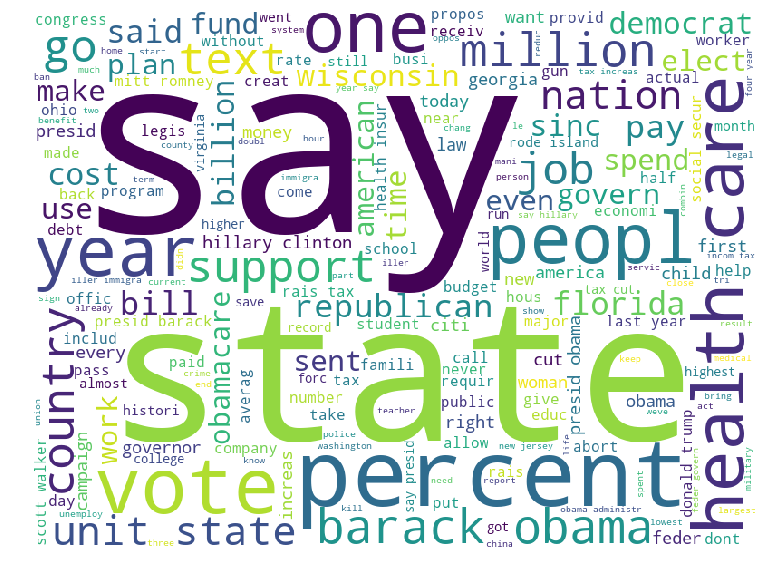

In [14]:
def cloud(data,backgroundcolor = 'white', width = 800, height = 600):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
cloud(' '.join(train_news['clean']))

#### Inferences from visulaization: 
- The large words are the words that are frequently appeared in the text/corpus

## Feature: Corpus Structure

In [644]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import metrics

In [654]:
class CorpusStructure():
    
    def __init__(self):
        
        self.logisticRegression_pipeline = ''
        self.rf_pipeline = ''
        
        self.logisticRegression_enrich_pipeline = ''
        self.rf_enrich_pipeline = ''
    
    # binarize output label
    def binarizeOutputLabel(self, r):
        v = r['label']

        # consider 'true', 'mostly-true', 'half-true' as 1, others as 0
        if (v == 'true'):
            return 1
        if (v == 'mostly-true'):
            return 1
        if (v == 'half-true'):
            return 1
        if (v == 'barely-true'):
            return 0
        if (v == 'false'):
            return 0
        if (v == 'pants-fire'):
            return 0
    
    def logReg_pipline(self, ngram_rg=(1,1)):
    
        tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=ngram_rg)
        count_vectorizer = CountVectorizer(ngram_range=ngram_rg)
        
        X = count_vectorizer.fit_transform(train_news['clean'])
        # Testing the ngram generation:
        print("Get first 20 feature names:\n")
        print(count_vectorizer.get_feature_names()[: 20])
        print("\nPrint count vectorizer\n")
        print(X.toarray())
        
        X_train = tfidf_vectorizer.fit_transform(train_news['clean'].values)
        X_test = vectorizer.transform(test_news['clean'].values)
        
        train_news['binaryLabel'] = train_news.apply(lambda row: self.binarizeOutputLabel(row), axis=1)
        test_news['binaryLabel'] = train_news.apply(lambda row: self.binarizeOutputLabel(row), axis=1)

        y_train = train_news['binaryLabel']
        y_test = test_news['binaryLabel']
        
        self.logisticRegression_pipeline = Pipeline([
            ('vectorizer', tfidf_vectorizer),
            ('clf', LogisticRegression(penalty='l2', C=98.684210526315795))
            ])

        # print(X_train.shape)
        # print(y_train.shape)

        self.logisticRegression_pipeline.fit(train_news['clean'].values, y_train)
        predicts = self.logisticRegression_pipeline.predict(test_news['clean'].values)
        score = metrics.accuracy_score(y_test, predicts)
        print("\n\nWord Frequency Model Trained - accuracy:   %0.6f" % score)
        print("\n")
        print(classification_report(y_test, predicts))
        
        param_grid = [{'C': np.linspace(90,100,20)}]

        grid_cv = GridSearchCV(LogisticRegression(), param_grid, scoring='accuracy', cv=10, verbose=1)
        grid_cv.fit(X_train_text, y_train_text)
        
        print("Best Params:\n")
        print(grid_cv.best_params_)
        print("Best Score:\n")        
        print(grid_cv.best_score_)
        
    def logReg_predict(self, text):
        predicted = self.logisticRegression_pipeline.predict([text])
        predicedProb = self.logisticRegression_pipeline.predict_proba([text])[:,1]
        return bool(predicted), float(predicedProb)
    
    def rf_pipline(self, ngram_rg=(1,1)):
                
        tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=ngram_rg)
        count_vectorizer = CountVectorizer(ngram_range=ngram_rg)
        
        X = count_vectorizer.fit_transform(train_news['clean'])
        # Testing the ngram generation:
        # print("Get first 20 feature names:\n")
        # print(count_vectorizer.get_feature_names()[: 20])
        # print("\nPrint count vectorizer\n")
        # print(X.toarray())
        
        X_train = tfidf_vectorizer.fit_transform(train_news['clean'].values)
        X_test = vectorizer.transform(test_news['clean'].values)
        
        train_news['binaryLabel'] = train_news.apply(lambda row: self.binarizeOutputLabel(row), axis=1)
        test_news['binaryLabel'] = train_news.apply(lambda row: self.binarizeOutputLabel(row), axis=1)

        y_train = train_news['binaryLabel']
        y_test = test_news['binaryLabel']
        
        self.logisticRegression_pipeline = Pipeline([
            ('vectorizer', tfidf_vectorizer),
            ('clf', RandomForestClassifier(n_estimators = 300))
            ])

        # print(X_train.shape)
        # print(y_train.shape)

        self.logisticRegression_pipeline.fit(train_news['clean'].values, y_train)
        predicts = self.logisticRegression_pipeline.predict(test_news['clean'].values)
        score = metrics.accuracy_score(y_test, predicts)
        # Model Accuracy, how often is the classifier correct?
        print("Accuracy:",metrics.accuracy_score(y_test, predicts))

    def rf_predict(self, text):
        predicted = self.rf_pipline.predict([text])
        predicedProb = self.rf_pipline.predict_proba([text])[:,1]
        return bool(predicted), float(predicedProb)
    
    def data_enrichment(self):
        
        # Data enrichment
        # https://www.kaggle.com/snapcrack/all-the-news --- articles1
        df_articles = pd.read_csv("input_data/news/articles1.csv")
        df_articles.head(3)
        
        publications = np.unique(df_articles["publication"].values)
        print("publications:\n")
        print(publications)
        
        # We want to select several reputable publications for our dataset as well as several other 'less-reputable' publications in order to have a more balanced representation of news published by a real news publication company. Those we included are listed below.
        # We used a media bias/fact check website (source: https://mediabiasfactcheck.com/) to assess each news publication company. The results are below (each company is rated on their factual reporting).

        # Factual reporting:

        # Very High: reuters, npr
        # High: new york times, atlantic, guardian, washington post, vox
        # Mixed: fox news, cnn, national review
        df_articles = df_articles.loc[df_articles['publication'].isin(['New York Times', 'CNN','Atlantic','Fox News','Guardian','National Review','NPR','Reuters', 'Vox','Washington Post'])]
        # df_articles.head(3)
        # save to local csv file
        df_articles.to_csv('input_data/news/real_news.csv', encoding='utf-8')
        
        # https://www.kaggle.com/mrisdal/fake-news
        fake_news = pd.read_csv("input_data/news/fake.csv")
        # from local saved
        real_news = pd.read_csv("input_data/news/real_news.csv")
        
        real_news2 = real_news[['title', 'content', 'publication']]
        real_news2.dropna()
        real_news2['binaryLabel'] = 1
        real_news2.head(3)
    
        fake_news2 = fake_news[['title', 'text','site_url']]
        fake_news2.dropna()
        fake_news2['binaryLabel'] = 0
        fake_news2.head(5)
        
        # data cleaning
        fake_news2['clean'] = fake_news2['text'].apply(cleaning)
        real_news2['clean'] = real_news2['content'].apply(cleaning)
        print("After cleaning\n")
        fake_news2.head(3)
        real_news2.head(3)    
        
        # concatenate real and fake news data together
        data_news = [real_news2, fake_news2]
        df_news = pd.concat(data_news)[['clean', 'binaryLabel']]
        # train, test split
        df_train, df_test = train_test_split(df_news, test_size=0.2, random_state=0)
        
        # Enrich with original data frame
        df_news_enriched = [df_train, train_news]
        news_dataset = pd.concat(df_news_enriched)[['clean', 'binaryLabel']]
        #news_dataset.head(3)
        
        X_train_enrich = vectorizer.fit_transform(news_dataset['clean'].values)
        y_train_enrich = news_dataset['binaryLabel']
        
        X_test_enrich = [test_news, df_test]
        df_test_enrich = pd.concat(X_test_enrich)[['clean', 'binaryLabel']]
        X_test_enrich_clean = vectorizer.transform(df_test_enrich['clean'])
        X_test_enrich_clean.shape
        
        y_test_enrich = [y_test_text, df_test['binaryLabel']]
        df_y_test_enrich = pd.concat(y_test_enrich)
        df_y_test_enrich
        
        return news_dataset, df_test_enrich, df_y_test_enrich;
    
    def logReg_enrich_pipline(self, ngram_rg=(1,1)):
        
        news_dataset, df_test_enrich, df_y_test_enrich = self.data_enrichment()

        tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=ngram_rg)

        self.logisticRegression_enrich_pipeline = Pipeline([
            ('vectorizer', tfidf_vectorizer),
            ('clf', LogisticRegression(penalty='l2', C=98.684210526315795))
            ])

        self.logisticRegression_enrich_pipeline.fit(news_dataset['clean'].values, news_dataset['binaryLabel'])
        predicts = self.logisticRegression_enrich_pipeline.predict(df_test_enrich['clean'].values)
        score = metrics.accuracy_score(df_y_test_enrich, predicts)
        # Model Accuracy, how often is the classifier correct?
        print("Accuracy:",metrics.accuracy_score(df_y_test_enrich, predicts))
        
        
    def rf_enrich_pipline(self, ngram_rg=(1,1)):
        
        news_dataset, df_test_enrich, df_y_test_enrich = self.data_enrichment()

        tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=ngram_rg)

        self.rf_enrich_pipeline = Pipeline([
            ('vectorizer', tfidf_vectorizer),
            ('clf', RandomForestClassifier(n_estimators = 300))
            ])

        self.rf_enrich_pipeline.fit(news_dataset['clean'].values, news_dataset['binaryLabel'])
        predicts = self.rf_enrich_pipeline.predict(df_test_enrich['clean'].values)
        score = metrics.accuracy_score(df_y_test_enrich, predicts)
        # Model Accuracy, how often is the classifier correct?
        print("Accuracy:",metrics.accuracy_score(df_y_test_enrich, predicts))

In [655]:
corpusStructure = CorpusStructure()

In [658]:
corpusStructure.logReg_pipline(ngram_rg=(1,1))

Get first 20 feature names:

['aa', 'aaa', 'aaron', 'aarp', 'aba', 'abandon', 'abba', 'abbott', 'abc', 'abdul', 'abel', 'abid', 'abig', 'abil', 'abject', 'abl', 'aboard', 'abolish', 'abort', 'abortioneven']

Print count vectorizer

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)




Word Frequency Model Trained - accuracy:   0.516180


              precision    recall  f1-score   support

           0       0.44      0.40      0.42       551
           1       0.57      0.60      0.58       716

   micro avg       0.52      0.52      0.52      1267
   macro avg       0.50      0.50      0.50      1267
weighted avg       0.51      0.52      0.51      1267

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best Params:

{'C': 90.0}
Best Score:

0.56591796875


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    4.7s finished


In [659]:
corpusStructure.rf_pipline(ngram_rg=(1,1))

Accuracy: 0.5122336227308603


In [628]:
corpusStructure.logReg_pipline(ngram_rg=(2,2))

Get first 20 feature names:

['aa aaa', 'aaa bond', 'aaa credit', 'aaron bean', 'aarp consist', 'aarp largest', 'aarp say', 'aarp vendors', 'aba criterion', 'abandon dollar', 'abandon home', 'abandon republican', 'abba leader', 'abba one', 'abbott becom', 'abbott benefit', 'abbott campaign', 'abbott charg', 'abbott convert', 'abbott defend']

Print count vectorizer

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)




Word Frequency Model Trained - accuracy:   0.508287


              precision    recall  f1-score   support

           0       0.44      0.48      0.46       551
           1       0.57      0.53      0.55       716

   micro avg       0.51      0.51      0.51      1267
   macro avg       0.50      0.50      0.50      1267
weighted avg       0.51      0.51      0.51      1267

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best Params:

{'C': 90.0}
Best Score:

0.56591796875


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    4.9s finished


In [629]:
corpusStructure.rf_pipline(ngram_rg=(2,2))

Accuracy: 0.4988161010260458


In [660]:
corpusStructure.logReg_pipline(ngram_rg=(3,3))

Get first 20 feature names:

['aa aaa bond', 'aaa bond rate', 'aaa credit rate', 'aaron bean vote', 'aarp consist communis', 'aarp largest rebel', 'aarp say health', 'aarp vendors health', 'aba criterion judicial', 'abandon dollar multi', 'abandon home serv', 'abandon republican stood', 'abba leader fatal', 'abba one member', 'abbott becom attorney', 'abbott benefit payday', 'abbott campaign sexual', 'abbott charg overs', 'abbott convert million', 'abbott defend billion']

Print count vectorizer

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)




Word Frequency Model Trained - accuracy:   0.532755


              precision    recall  f1-score   support

           0       0.40      0.15      0.21       551
           1       0.56      0.83      0.67       716

   micro avg       0.53      0.53      0.53      1267
   macro avg       0.48      0.49      0.44      1267
weighted avg       0.49      0.53      0.47      1267

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best Params:

{'C': 90.0}
Best Score:

0.56591796875


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    4.7s finished


In [661]:
corpusStructure.rf_pipline(ngram_rg=(3,3))

Accuracy: 0.5390686661404893


In [656]:
corpusStructure.logReg_enrich_pipline()

publications:

['Atlantic' 'Breitbart' 'Business Insider' 'CNN' 'New York Times']


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

After cleaning



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Accuracy: 0.8768041237113402


In [657]:
corpusStructure.rf_enrich_pipline()

publications:

['Atlantic' 'Breitbart' 'Business Insider' 'CNN' 'New York Times']


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

After cleaning



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:181: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Accuracy: 0.8829896907216495
